In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [5]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from particle_detection.data.data_pipeline import create_dataloaders
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.utils.model_utils import load_model
from particle_detection.clustering.cluster_visualization import process_and_visualize_clusters, visualize_binary_clusters, compare_original_and_clusters
from particle_detection.utils.pca_preprocessing import apply_pca, plot_explained_variance

In [6]:
data_dir = "../data"
#data_dir = "/home/blah-buttery/nanoparticles/images/normal" #gpu ws 
#dataset_dir = "/Users/blah_m4/Desktop/nanoparticle/images" # macbook

image_size = (2048, 2048)
batch_size = 8

train_loader, test_loader = create_dataloaders(data_dir=data_dir, image_size=image_size, batch_size=batch_size)

In [7]:
model_path = "../saved_models/ae_1000_epochs.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder = create_autoencoder().to(device)
autoencoder = load_model(autoencoder, model_path, device=device)
autoencoder.eval()

print("Model loaded successfully.")

Loading model from: ../saved_models/ae_1000_epochs.pth
Model loaded successfully from ../saved_models/ae_1000_epochs.pth.
Model loaded successfully.


In [8]:
# get the latent space by passing dataset through encoder
sample_img = next(iter(test_loader))
sample_img = sample_img.to(device)

with torch.no_grad():
    latent_space = autoencoder.encoder(sample_img)
    print(f"Shape of latent space: {latent_space.shape}")

Shape of latent space: torch.Size([3, 512, 128, 128])


In [9]:
latent_space_reshaped = latent_space.permute(0, 2, 3, 1).reshape(-1, latent_space.shape[1])
print(f"Shape of reshaped latent space: {latent_space_reshaped.shape}")

Shape of reshaped latent space: torch.Size([49152, 512])


In [10]:
latent_space_normalized = StandardScaler().fit_transform(latent_space_reshaped.cpu().numpy())

dbscan = DBSCAN(eps=10, min_samples=5)
cluster_labels = dbscan.fit_predict(latent_space_normalized)

num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_noise_points = list(cluster_labels).count(-1)

print(f"Number of clusters found: {num_clusters}")
print(f"Number of noise points: {num_noise_points}")

Number of clusters found: 2
Number of noise points: 7604


In [11]:
# map clusters back to grid shape
grid_cols = latent_space.shape[3]
grid_rows = latent_space.shape[2]
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)

print(f"Cluster labels shape: {cluster_labels.shape}")
print(f"Cluster labels grid shape: {cluster_labels_grid.shape}")

Cluster labels shape: (49152,)
Cluster labels grid shape: (3, 128, 128)


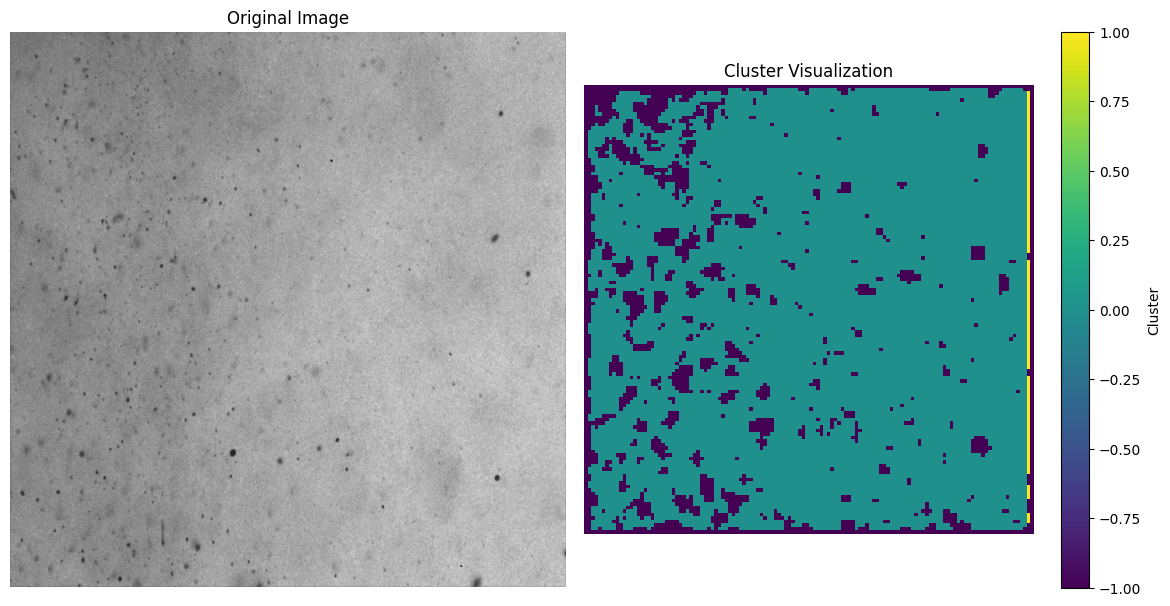

In [12]:
compare_original_and_clusters(sample_img, cluster_labels_grid)

Unique cluster labels: [-1  0  1]


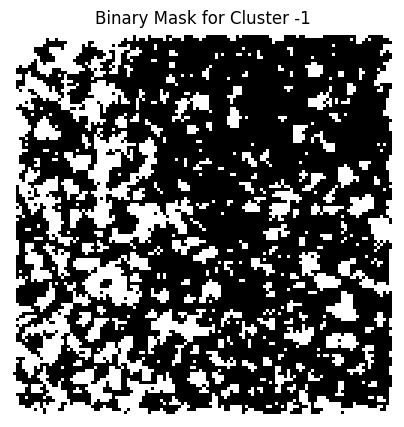

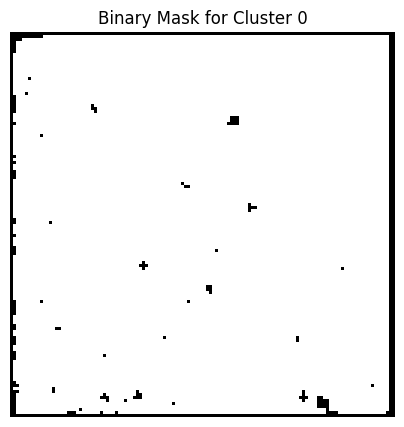

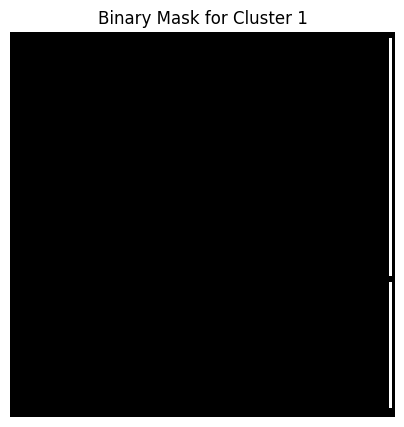

In [13]:
visualize_binary_clusters(cluster_labels_grid)

### There is the issue! cluster -1 is detecting the particles

Lets go through our optimization steps and see if we can get better results. 

In [14]:
latent_space_np = latent_space_reshaped.cpu().numpy()
latent_space_pca, pca = apply_pca(latent_space_np, n_components=50)
print(f"Shape after PCA: {latent_space_pca.shape}")

Shape after PCA: (49152, 29)


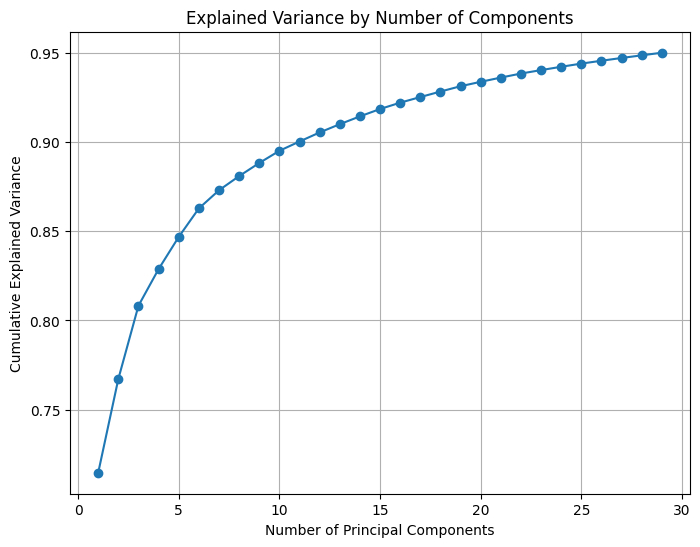

In [15]:
plot_explained_variance(pca)

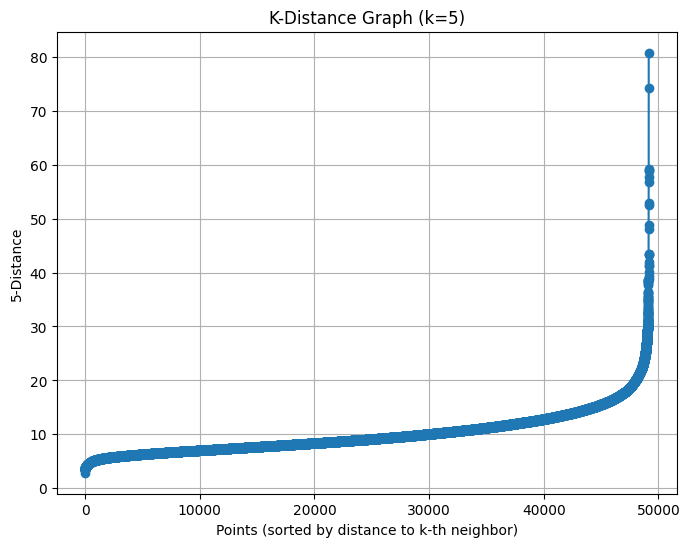

In [16]:
def plot_k_distance(data, k=5):
    """
    Plots the k-distance graph to help select the `eps` parameter for DBSCAN.
    
    Args:
        data (np.ndarray): Data for DBSCAN, shape [N, features].
        k (int): The k-th nearest neighbor to calculate distances for.
    
    Returns:
        None (plots the k-distance graph).
    """
    # Fit Nearest Neighbors model
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    
    # Find distances to the k-th nearest neighbor for each point
    distances, _ = nbrs.kneighbors(data)
    
    k_distances = np.sort(distances[:, k-1])
    
    # Plot the sorted k-distances
    plt.figure(figsize=(8, 6))
    plt.plot(k_distances, marker='o')
    plt.title(f"K-Distance Graph (k={k})")
    plt.xlabel("Points (sorted by distance to k-th neighbor)")
    plt.ylabel(f"{k}-Distance")
    plt.grid()
    plt.show()

plot_k_distance(latent_space_pca, k=5)

In [17]:
dbscan = DBSCAN(eps=10.5, min_samples=10)
cluster_labels = dbscan.fit_predict(latent_space_pca)
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)

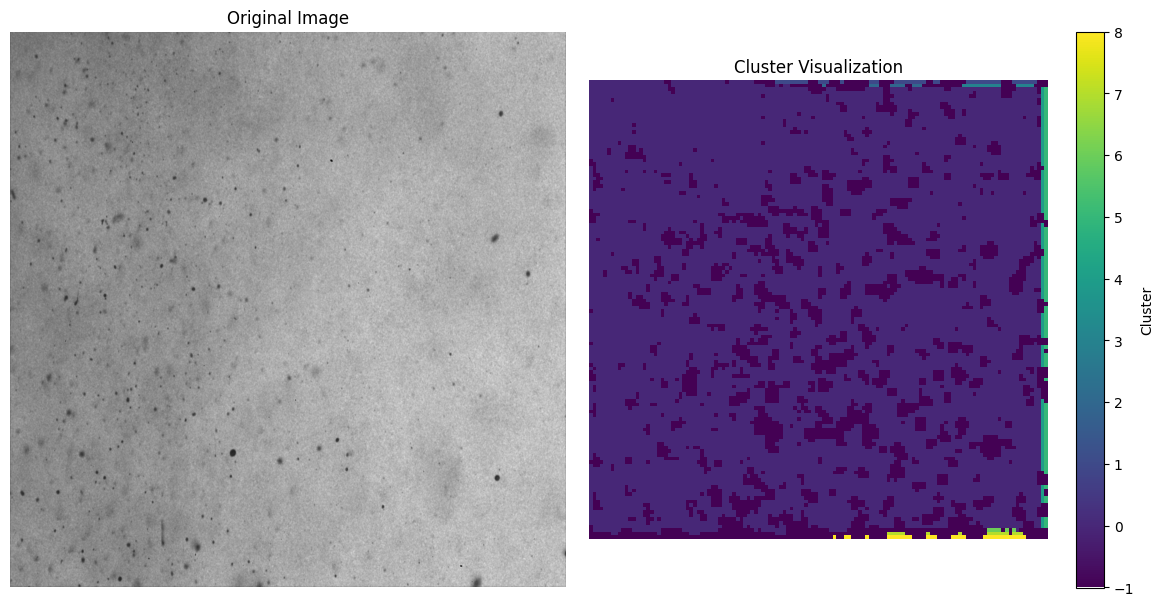

In [18]:
compare_original_and_clusters(sample_img, cluster_labels_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


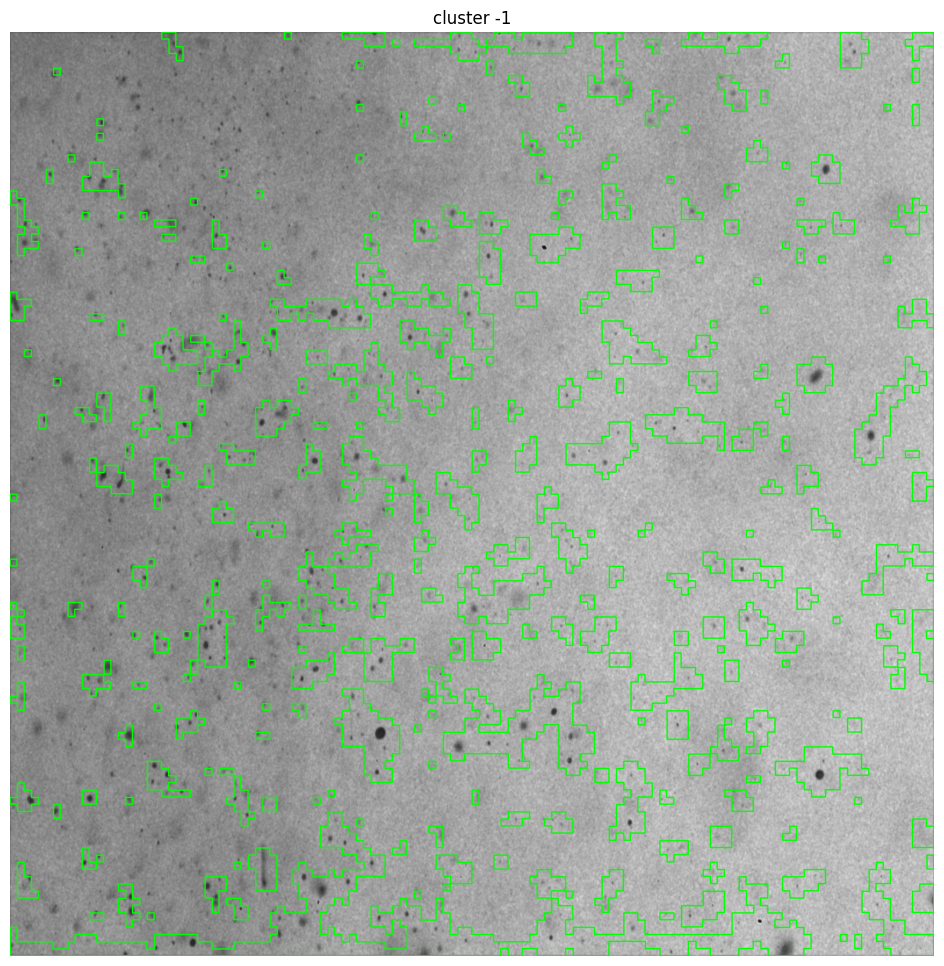

In [19]:
process_and_visualize_clusters(sample_img, cluster_labels_grid, cluster_id=-1, no_filter=True, title="cluster -1")

Better results but lets try grid search to find the best option. Recall: We are looking for the worst score because -1 is detecting the particles.

In [ ]:
def dbscan_grid_search(data, eps_range, min_samples_range):
    """
    DBSCAN grid search for finding the best parameters.
    Logs all results for graphing and evaluates all combinations without skipping.
    
    Args:
        data (np.ndarray): Dataset to cluster (shape: [n_samples, n_features]).
        eps_range (iterable): Range of eps values to evaluate.
        min_samples_range (iterable): Range of min_samples values to evaluate.

    Returns:
        best_model (DBSCAN): The best DBSCAN model based on silhouette score.
        best_params (dict): Parameters of the best DBSCAN model.
        best_score (float): Best silhouette score achieved.
        results_df (pd.DataFrame): DataFrame of all results for graphing.
    """
    best_model = None
    best_score = -1  # Silhouette score ranges from -1 to 1
    best_params = {}
    results = []

    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)

            # fails if -1 all noise points or only one cluster
            if len(set(labels)) > 1:
                score = silhouette_score(data, labels)
                results.append({"eps": eps, "min_samples": min_samples, "score": score})
                print(f"Silhouette Score for eps={eps}, min_samples={min_samples}: {score}")

                # Update if score improves
                if score > best_score:
                    best_score = score
                    best_model = dbscan
                    best_params = {"eps": eps, "min_samples": min_samples}
            else:
                # Log invalid clustering with a score of -1
                results.append({"eps": eps, "min_samples": min_samples, "score": -1})
                print(f"Invalid clustering for eps={eps}, min_samples={min_samples}")

    results_df = pd.DataFrame(results)
    print(f"Best parameters: {best_params}, Best Silhouette Score: {best_score}")
    return best_model, best_params, best_score, results_df

In [ ]:
eps_range = np.arange(5, 12, 1)
min_samples_range = range(5, 10)

best_dbscan, best_params, best_score, results_df = dbscan_grid_search(latent_space_pca, eps_range, min_samples_range)

plt.figure(figsize=(10, 6))
for min_samples in results_df["min_samples"].unique():
    subset = results_df[results_df["min_samples"] == min_samples]
    plt.plot(subset["eps"], subset["score"], label=f"min_samples={min_samples}")

plt.title("DBSCAN Silhouette Scores")
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid()
plt.show()

In [20]:
dbscan = DBSCAN(eps=7, min_samples=5)
cluster_labels = dbscan.fit_predict(latent_space_pca)

In [21]:
cluster_labels_grid = cluster_labels.reshape(latent_space.shape[0], grid_rows, grid_cols)

Unique cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


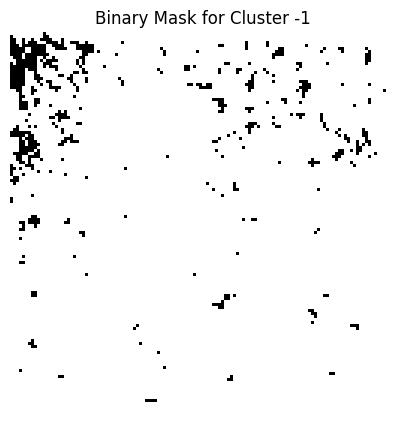

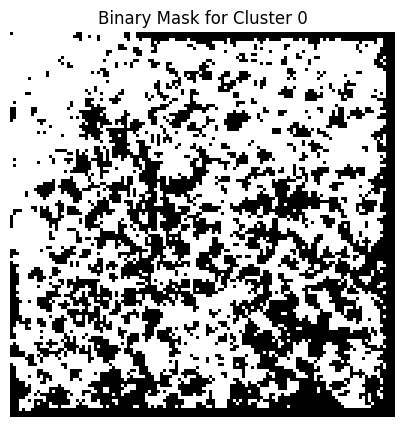

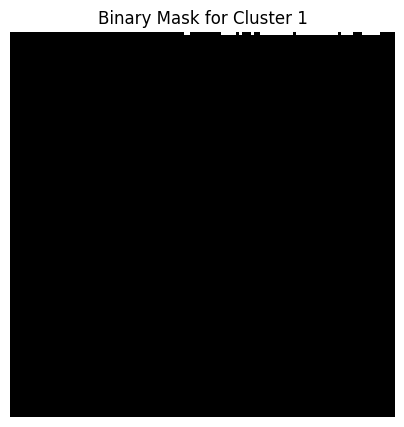

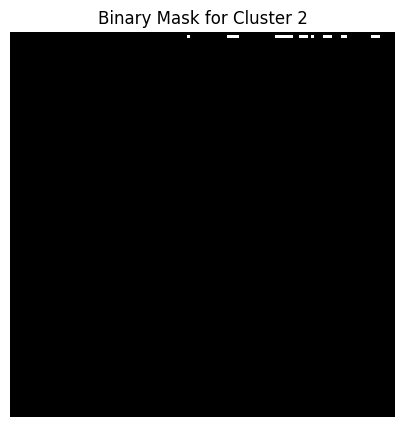

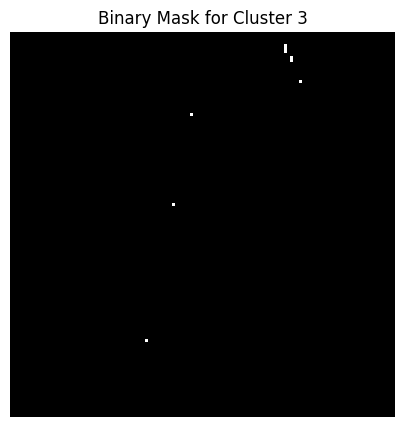

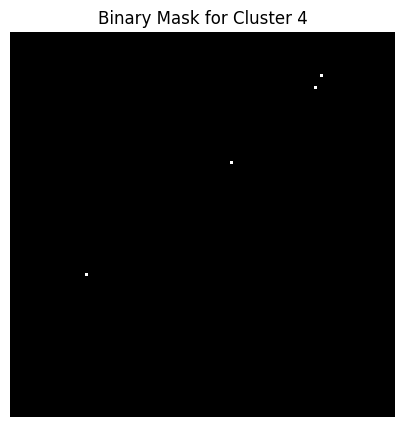

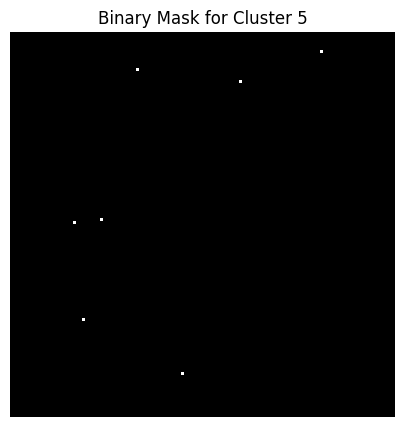

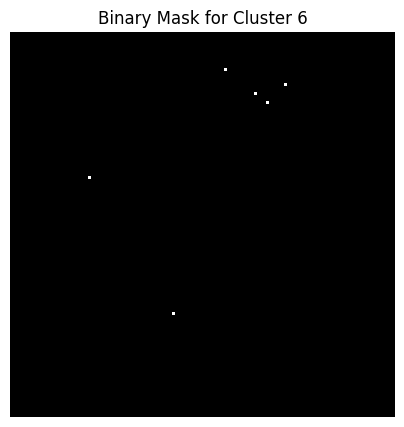

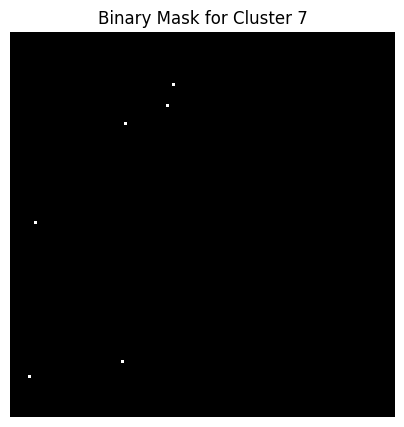

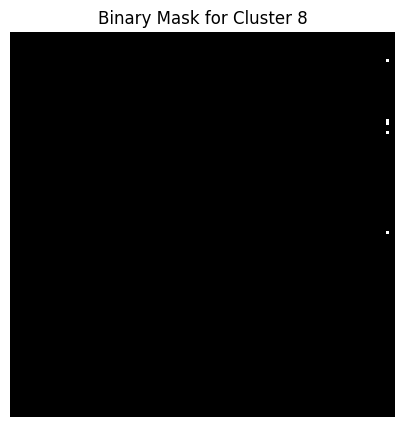

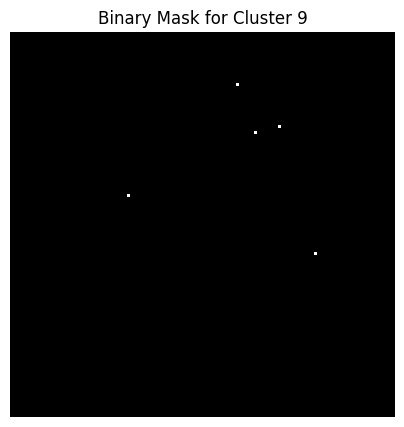

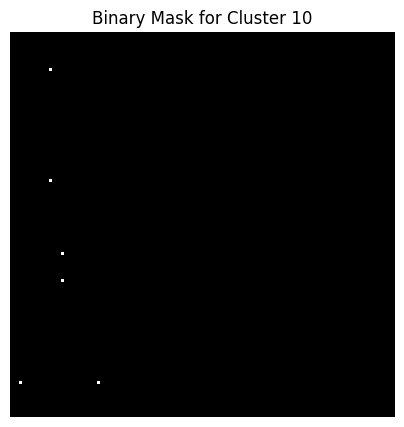

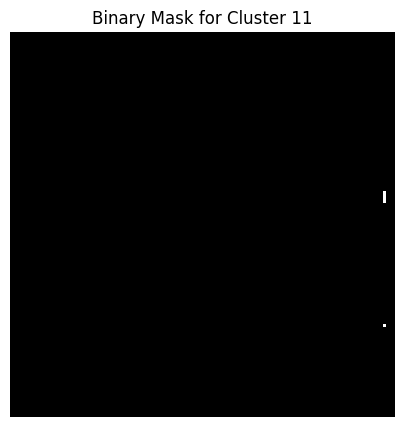

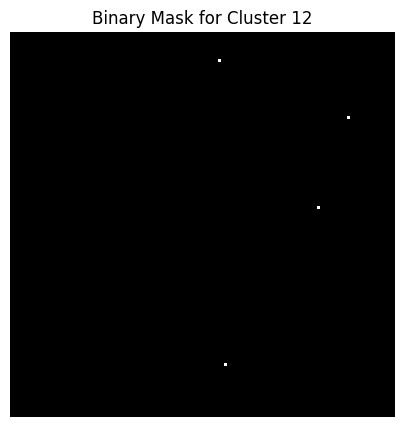

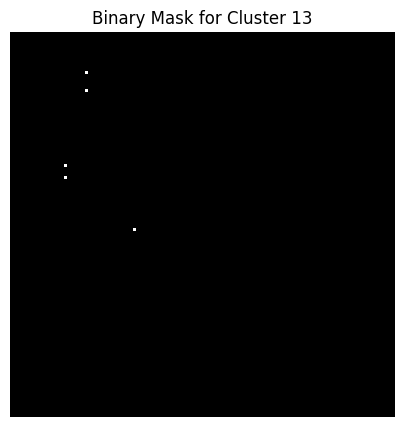

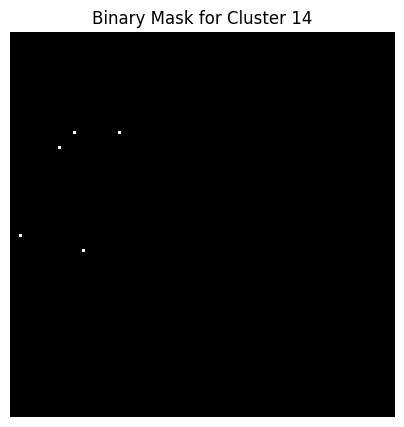

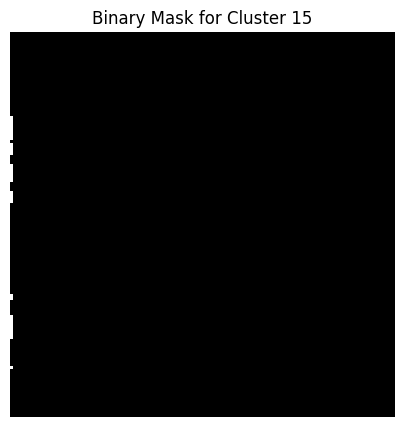

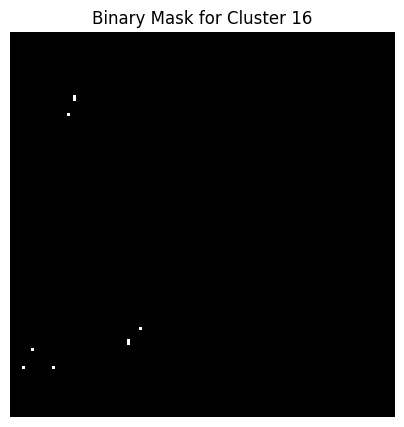

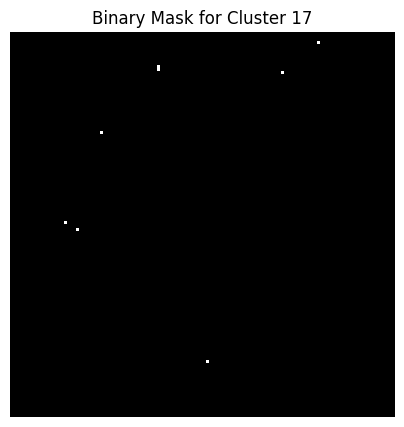

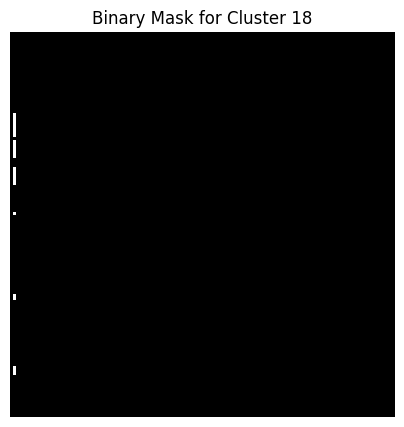

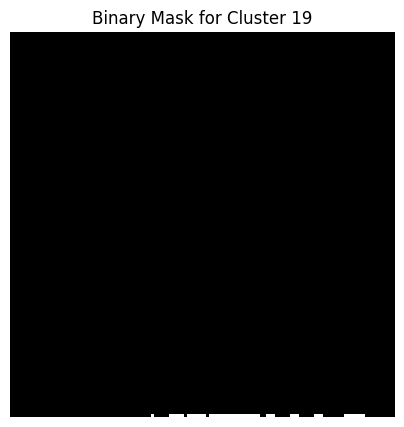

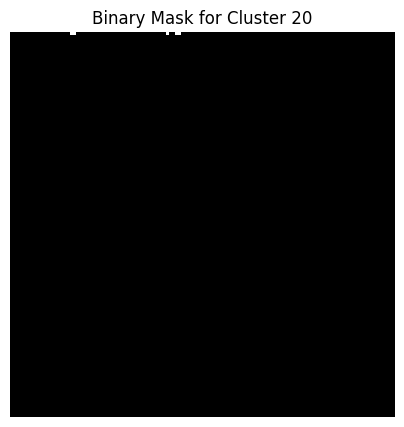

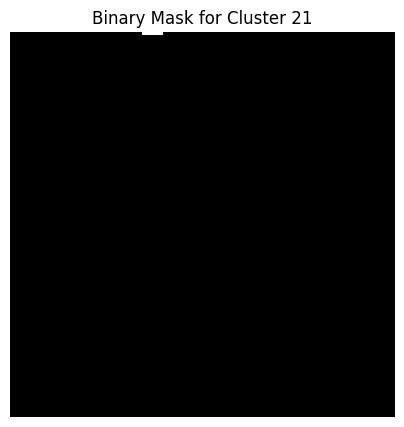

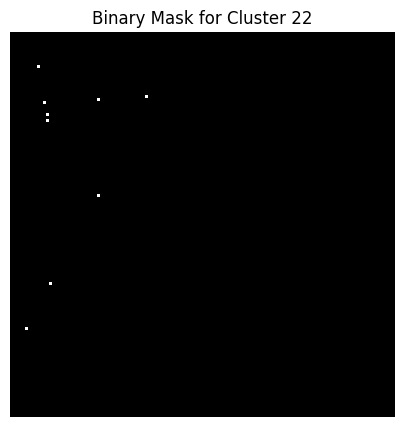

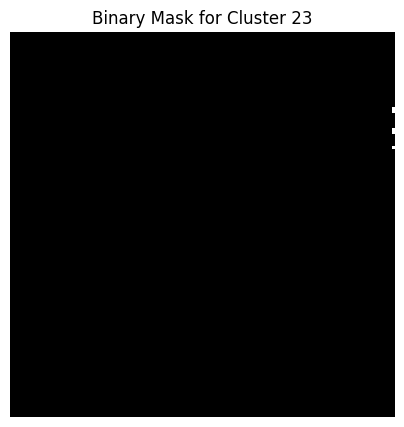

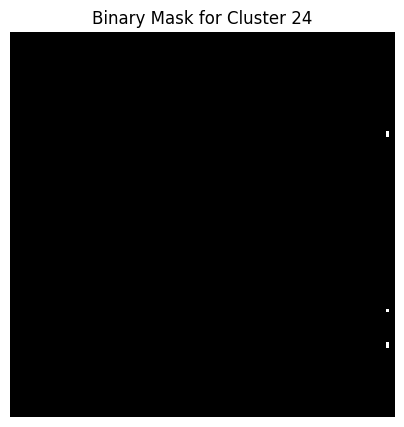

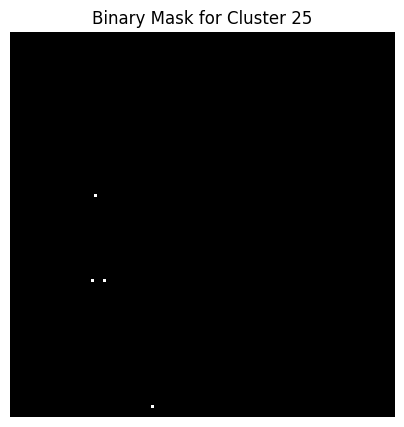

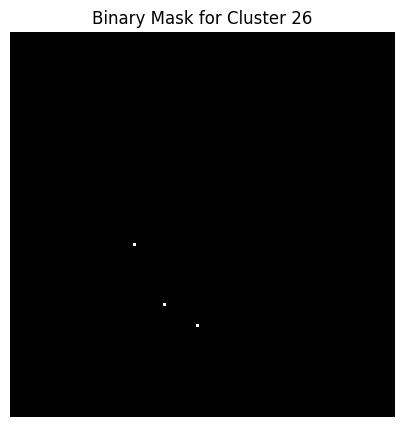

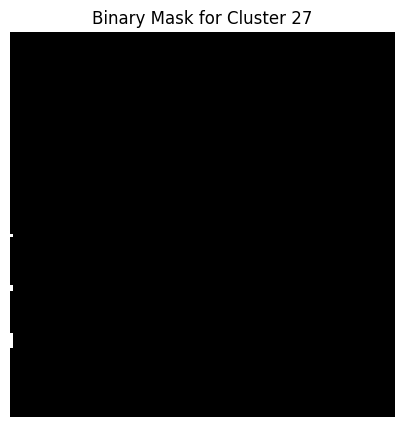

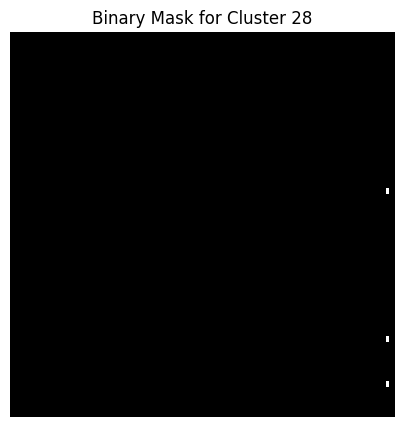

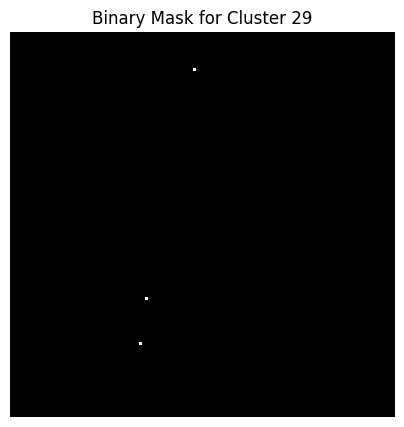

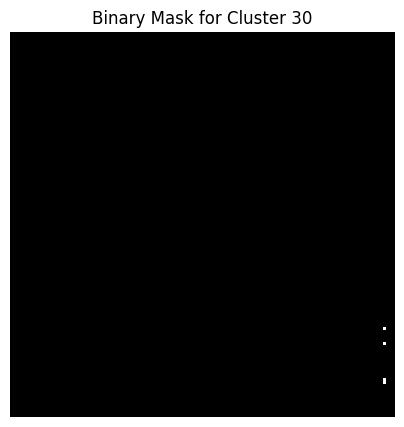

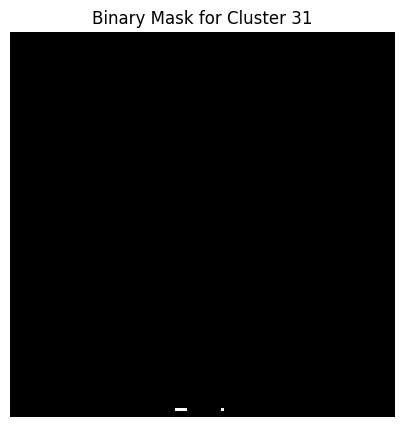

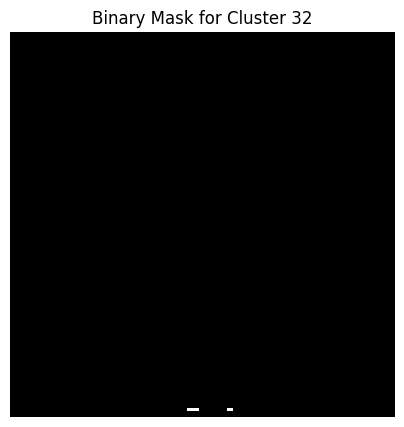

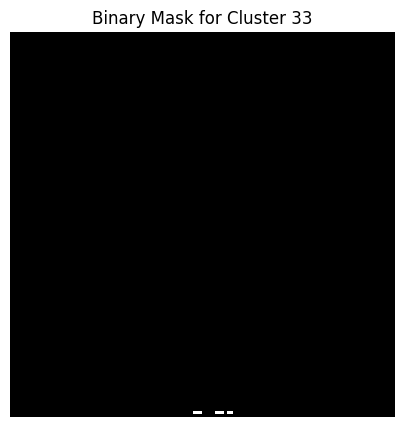

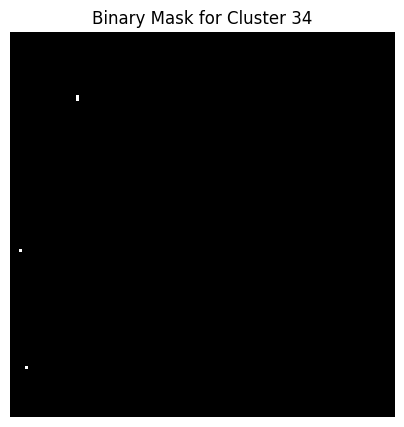

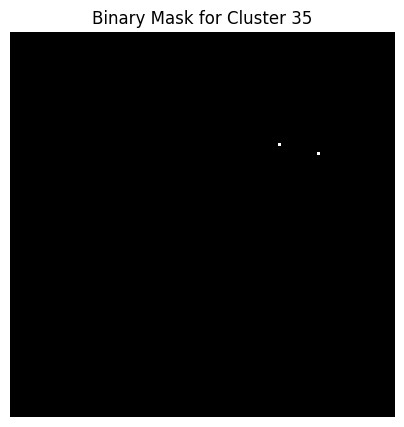

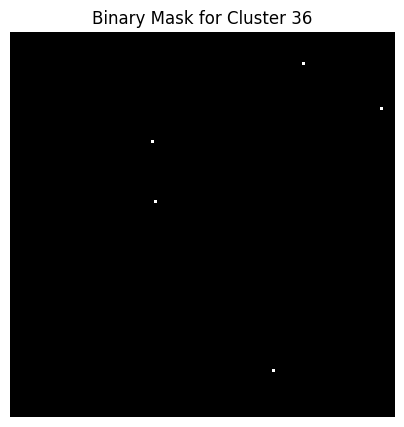

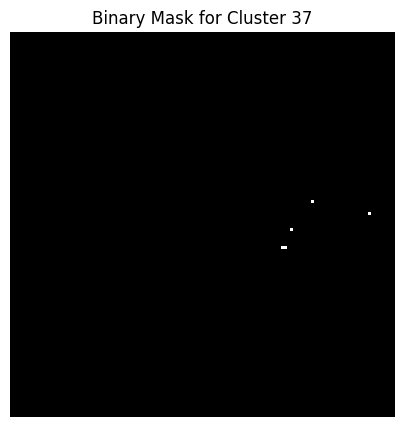

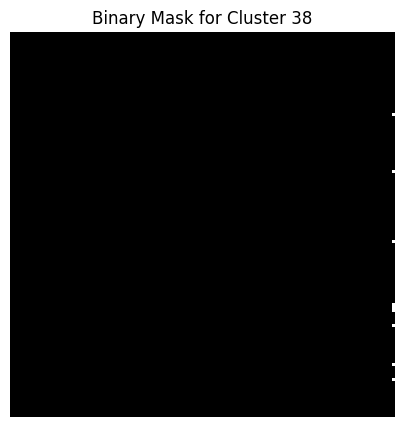

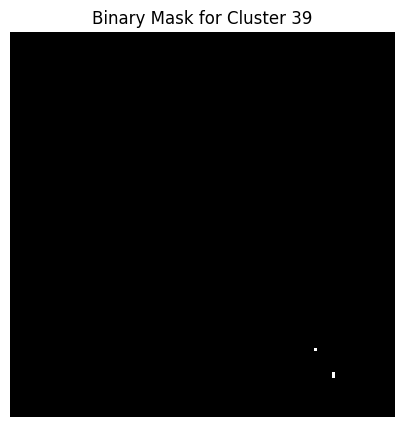

In [22]:
visualize_binary_clusters(cluster_labels_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


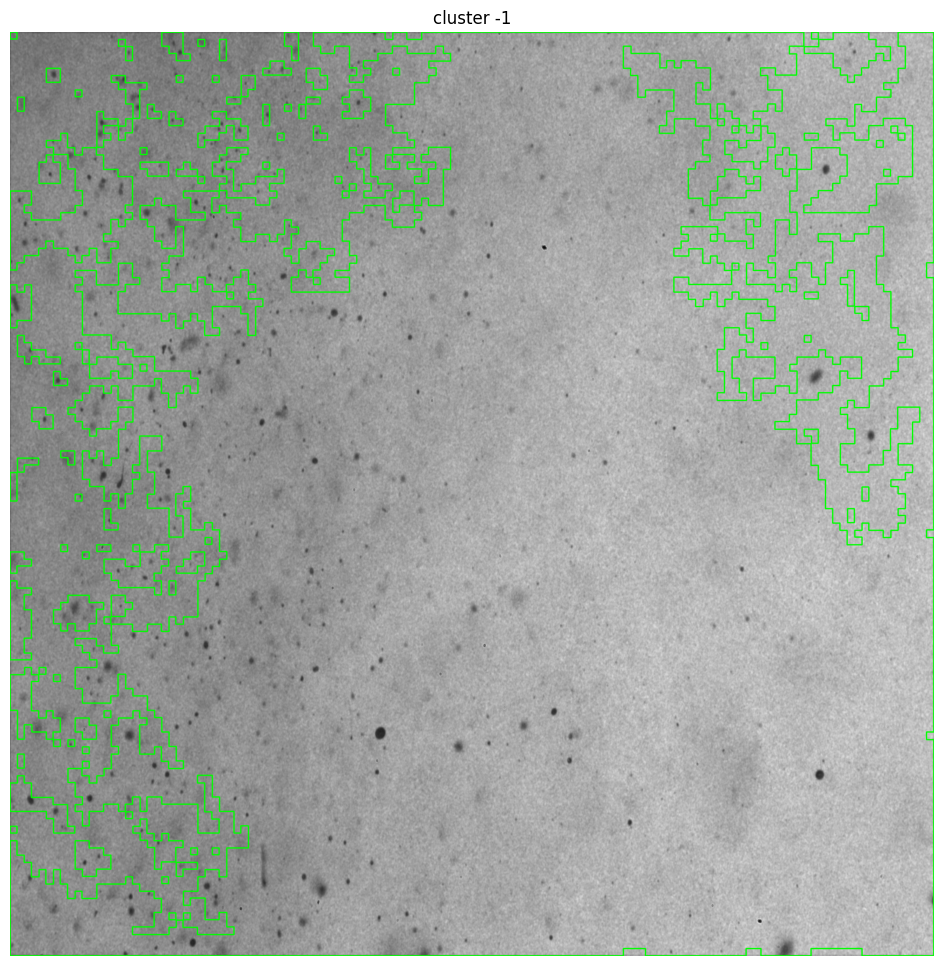

In [23]:
process_and_visualize_clusters(sample_img, cluster_labels_grid, cluster_id=-1, no_filter=True, title="cluster -1")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


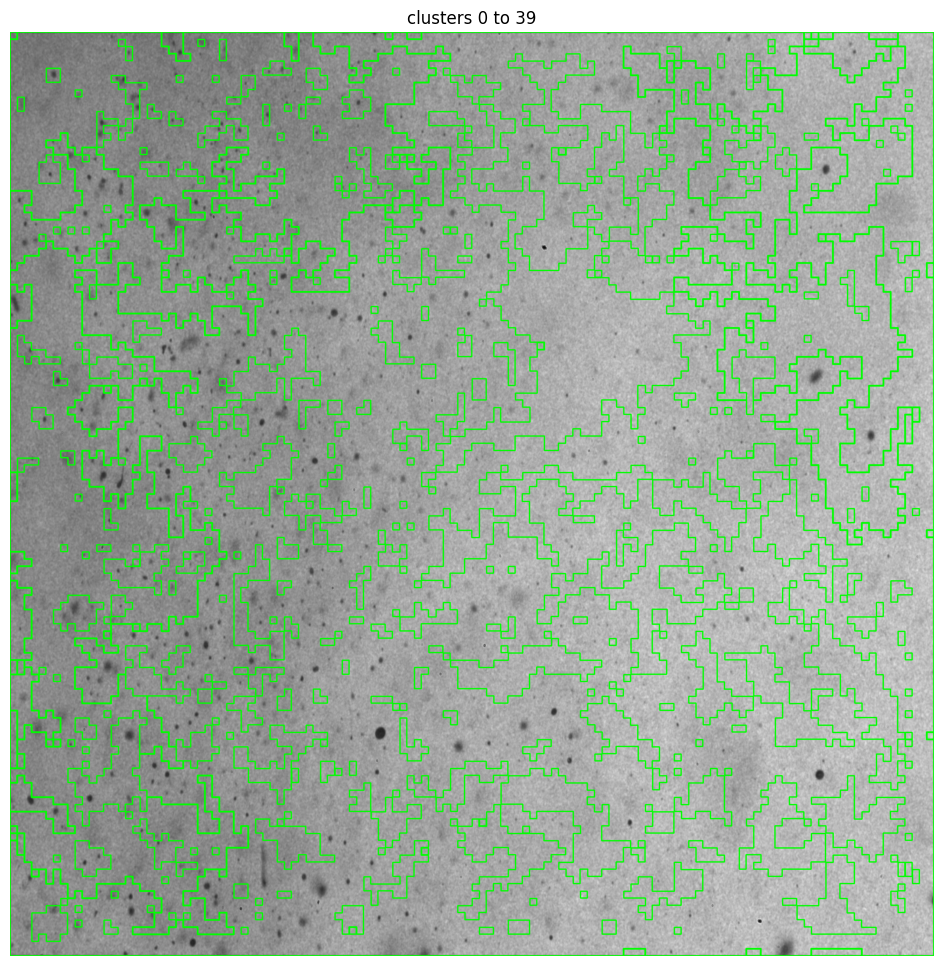

In [24]:
process_and_visualize_clusters(sample_img, cluster_labels_grid, cluster_id=None, no_filter=True, title="clusters 0 to 39")

so from these results it looks like eps=10.5 and min_samples=10 give the best results.